# CLIP-Automodulator

## Instructions
* You only need to edit the 'Start here' section of this notebook
* You need 20 GB of memory to retrain, which Collab usually does not give you.
* Your own input images need to be aligned as the example images here, see e.g. Automodulator official Collab notebook.
* Higher learning rate (lr) = faster results, lower quality.
* If you are missing some of the standard ML libraries, follow the error messages and then install with pip or conda.

## Boilerplate

In [ ]:
!pwd #Ensure you start at clip-automodulator

In [ ]:
!git clone https://github.com/openai/CLIP                 &> /dev/null
!pip install -e ./CLIP                                    
!git clone https://github.com/heljakka/automodulator.git

In [ ]:
from CLIP import clip
import sys
import os
import torch
from torch import optim
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
import copy
from tqdm import tqdm

%matplotlib inline
%cd automodulator
sys.argv = ['none']
from pioneer.model import SpectralNorm
import pioneer.utils
from pioneer.session import accumulate

In [25]:
from torchvision import transforms

In [5]:
!rm pioneer/session.py
!wget "https://gist.githubusercontent.com/heljakka/38538b5e91b88fd477b0e784727c6943/raw/2b36a6570c985d3aef9c49817bde58b3bd86badd/session.py" -P pioneer

--2022-04-06 21:15:07--  https://gist.githubusercontent.com/heljakka/38538b5e91b88fd477b0e784727c6943/raw/2b36a6570c985d3aef9c49817bde58b3bd86badd/session.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15242 (15K) [text/plain]
Saving to: ‘pioneer/session.py’

session.py          100%[===================>]  14,88K  --.-KB/s    in 0,001s  

2022-04-06 21:15:07 (17,6 MB/s) - ‘pioneer/session.py’ saved [15242/15242]



## Visualization

In [138]:
def accumulate(model1, model2, decay=0.999): # From pioneer/session.py
    par1 = dict(model1.named_parameters())
    par2 = dict(model2.named_parameters())

    for k in par1.keys():
        par1[k].data.mul_(decay).add_(1 - decay, par2[k].data)

def show(img):
    npimg = img.numpy()
    npimg = npimg / (abs(npimg).max() + 0.000001) #Remove a useless warning about number ranges and scaling
    plt.imshow(np.transpose(npimg, (1,2,0)) / 2 + 0.5, interpolation='nearest')
def show_pairs(imgs1, imgs2):

    t = torch.FloatTensor(imgs1.size(0) * 2, imgs1.size(1),
                          imgs1.size(2), imgs1.size(3))

    t[0::2] = imgs1[:]
    t[1::2] = imgs2[:]

    grid = (make_grid(t[:imgs1.size(0)*2] , padding=5, nrow=2))

    fig = plt.figure(figsize=(8,8))
    show(grid)
    
    return grid

def reconstruct(simg, G, modulator, id, postfix, datatype='ffhq512'):
    # Reconstruct
    #modulator.g_running.module.use_layer_noise = False
    G.use_layer_noise = False
    with torch.no_grad():
        imgs = torch.stack([modulator.tf()(Image.open(img)) for img in simg])
        for i,img in enumerate(imgs):
        #imgs = torch.stack([modulator.tf()(Image.open(img))])
            z = modulator.encode(img)
            #omg = modulator.decode( modulator.zbuilder().hi(z).mid(z).lo(z))
            omg = G(z, None, modulator.getResoPhase(), 1.0)
            torchvision.utils.save_image(omg, normalize=True, fp=f'{postfix}/{datatype}_reco_{id}_{i}.png')
            show( torch.cat((img.cpu(), omg[0].cpu()), dim=2).detach() )


In [ ]:
def local_load_test(suffix, checkpoint, simg, noise = False):
    modulator = torch.hub.load('heljakka/automodulator', 'ffhq512', pretrained=True, source='github')
    modulator._load(torch.load(f'{suffix}/modulator-{suffix}_{checkpoint}.pth'))
    modulator.g_running.module.use_layer_noise = noise # Avoid copying of g_running over generator
    SpectralNorm.eval()

    G = modulator.g_running
   
    for i in range(len(simg)):
        imgs = torch.stack([modulator.tf()(Image.open(simg[i]))])
        z = modulator.encode(imgs)
        omg = G.module(z, None, modulator.getResoPhase(), 1.0)
        torchvision.utils.save_image(omg[0], normalize=True, fp=f'reco_{suffix}_{checkpoint}_{i}.png')

    random_images, zs = modulator.generate(4)
    torchvision.utils.save_image(random_images, normalize=True, fp=f'rand_{suffix}_{checkpoint}.png')

## Training loop

In [105]:
class Trainer:
    def __init__(self, target_prompt, postfix, src_prompt = "a photo", lr = 0.00003):
        self.modulator = torch.hub.load('heljakka/automodulator', 'ffhq512', pretrained=True, source='github')
        self.modulator.eval(useLN=False) # Loads g_running into generator
        self.modulator_frozen = torch.hub.load('heljakka/automodulator', 'ffhq512', pretrained=True, source='github')
        #self.modulator.eval(useLN=False)

        #SpectralNorm.train() # It's not clear if the SpectralNorm actually trains properly in the current scheme

        device = 'cuda'
        self.datatype = 'ffhq512'
        self.postfix = postfix

        self.clip_model, preprocess = clip.load("ViT-B/32", device=device)
        text = clip.tokenize([src_prompt, target_prompt]).to(device)

        with torch.no_grad():
            text_features = self.clip_model.encode_text(text)
            self.text_delta = text_features[1] - text_features[0]

        self.G = copy.deepcopy(self.modulator.g_running)
        self.G.module.use_layer_noise = False
        self.modulator_frozen.generator.module.use_layer_noise = False
        self.clip_model.requires_grad_(False)
        pioneer.utils.switch_grad_updates_to_first_of(self.G, self.modulator.encoder)

        self.opt = optim.Adam(self.G.module.parameters(), lr, betas=(0.0, 0.99))

        if not os.path.exists(postfix):
            os.makedirs(postfix)

    def train(self, iters):
        pbar = tqdm(range(iters))
        for i in pbar:
            with torch.no_grad():
                random_images, zs = self.modulator_frozen.generate(8)
                random_images = torch.nn.functional.interpolate(random_images, 224, mode="bilinear")
                img_image_features = self.clip_model.encode_image(random_images)

            self.opt.zero_grad()
            omg = self.G(zs, None, self.modulator.getResoPhase(), 1.0)
            if i%5 == 0:
                accumulate(self.modulator.g_running, self.G)
            omg = torch.nn.functional.interpolate(omg, 224, mode="bilinear")
            omg_image_features = self.clip_model.encode_image(omg)
            img_delta = omg_image_features - img_image_features
            dist = -torch.nn.CosineSimilarity(dim=1)(self.text_delta, img_delta)
            pbar.set_description(f'Loss at {i}: {dist.mean().item()}')
            loss = dist.sum()

            loss.backward()
            self.opt.step()

            # Visualizations

            if i%250 == 0 and i > 0:
                with torch.no_grad():
                    omg2 = self.modulator.g_running(zs, None, self.modulator.getResoPhase(), 1.0) # The same image from the mean of the generator
                    omg2 = torch.nn.functional.interpolate(omg2, 224, mode="bilinear")
                    #img_pair = torch.cat(((2*(random_images[0]-0.5)), omg[0], 2*(omg2[0]-0.5)), dim=2).detach().cpu()
                    img_pair = torch.cat((random_images[0], omg[0], omg2[0]), dim=2).detach().cpu()
                show(img_pair)
                torchvision.utils.save_image(img_pair/2+0.5, f'{self.postfix}/img_pair_{i}.png')
                if i%2500 == 0 and i > 0:
                    self.modulator.save_all(f'{self.postfix}/modulator-{self.postfix}_{i}.pth')
                    print('Checkpointed')

            #if i%5 == 0:
            #    reconstruct(simg=['fig/source-0.png'], modulator=self.modulator, id=i, postfix=self.postfix, datatype=self.datatype)

## Start here

Using cache found in /home/ari/.cache/torch/hub/heljakka_automodulator_master


Using  1  GPUs!
Remote load from https://zenodo.org/record/4298894/files/42420000_state.pth?download=1
LR in optimizer update: 0.001 => 0.0001
LR in optimizer update: 0.001 => 0.0001
LR in optimizer update: 0.001 => 0.0001
Reloaded old optimizers
Adaptive Losses loaded.
Load SNU from the model file
Found 18 SNU entries
Session created.


Using cache found in /home/ari/.cache/torch/hub/heljakka_automodulator_master


Using  1  GPUs!
Remote load from https://zenodo.org/record/4298894/files/42420000_state.pth?download=1
LR in optimizer update: 0.001 => 0.0001
LR in optimizer update: 0.001 => 0.0001
LR in optimizer update: 0.001 => 0.0001
Reloaded old optimizers
Adaptive Losses loaded.
Load SNU from the model file
Found 18 SNU entries
Session created.


Loss at 4: -0.034576416015625: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s] 


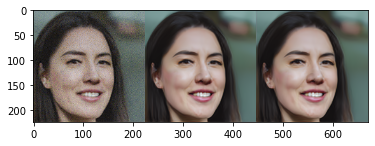

In [127]:
mode = 'train'
#mode = 'test'

if mode == 'train':
    #trainer = Trainer("a photo of Bruce Lee", 'bruce')
    #trainer = Trainer("a photo of a person with black eyes, light brown skin and strong chin", 'strong', lr=0.003)
    trainer = Trainer("a photo of an angel", 'angel', lr=0.0003)
    trainer.train(5)
else:
    local_load_test(suffix = 'bruce', checkpoint = 10000, 
                    simg = ['fig/source-0.png'],
                    noise=False)

Loss at 49: -0.219482421875: 100%|██████████| 50/50 [00:27<00:00,  1.80it/s] 


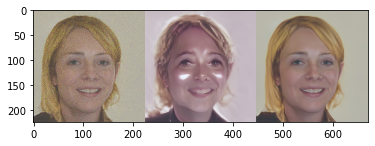

In [134]:
trainer.train(50)

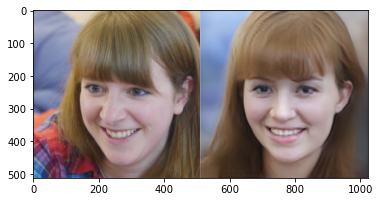

In [14]:
reconstruct(simg=['fig/source-4.png'], G=trainer.G, modulator=trainer.modulator, id=0, postfix='.')

In [ ]:
# Repeat the trainer.train(...) until you get nice transformations as below. For quality, YMMW.
# Feel free to improve the color balance in the plotting subroutine.
trainer.train(50)

### Angelic transformations

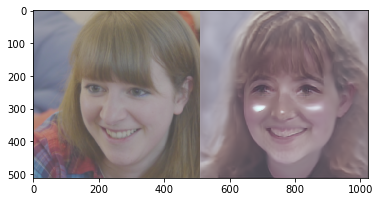

In [140]:
reconstruct(simg=['fig/source-4.png'], G=trainer.G, modulator=trainer.modulator, id=0, postfix='.')

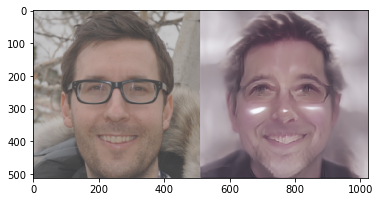

In [141]:
reconstruct(simg=['fig/source-3.png'], G=trainer.G, modulator=trainer.modulator, id=0, postfix='.')

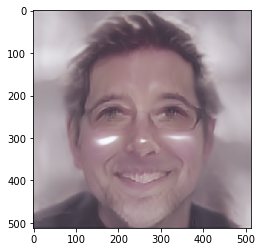

In [136]:
show(omg2[0].cpu())